# SOLRAD

The [SOLRAD](https://gml.noaa.gov/grad/solrad/) network consists of 9 surface radiation monitoring stations and is operated by the [National Oceanic and Atmospheric Administration (NOAA)](https://www.noaa.gov/).

The reader is referred to Hicks et al. (1996) for background information on the SOLRAD network.

```{admonition} Instrument calibrations
:class: dropdown
A list all instruments that have been used and their respective calibration coefficients can be found [here](https://gml.noaa.gov/grad/solrad/getcals.html).
```


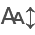

In [4]:
import pandas as pd
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

stations = pd.read_csv('../solarstations.csv').fillna('')
stations = stations[stations['Network'].str.contains('SOLRAD')]
del stations['URL']  # Remove the URL column to avoid cluttering the site

show(stations, scrollCollapse=True, paging=False, classes="display", order=[[0, "asc"]],
     showIndex=False, columnDefs=[{"className": "dt-left", "targets": "_all"}])

In [5]:
import folium
from folium import plugins

EsriImagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
EsriAttribution = "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"

# Create Folium map
m = folium.Map(
    location=[40, -100],
    zoom_start=3, min_zoom=2, max_bounds=True,
    control_scale=True,  # Adds distance scale in lower left corner
    tiles='openstreetmap',
)

# Add each station to the map
# Consider using apply instead of for loop to add stations in case of many stations
for index, row in stations.iterrows():
    color = 'blue'
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Station name'] + ' - ' + str(row['State']) + ' ' + row['Country'],
        tooltip=row['Abbreviation'],
        radius=5, # color=color, fill_color=color,
        fill=True).add_to(m)

folium.raster_layers.TileLayer(EsriImagery, name='World imagery', attr=EsriAttribution, show=False).add_to(m)
folium.LayerControl(position='topleft').add_to(m)

# Additional options and plugins
# Note it's not possible to change the position of the scale
plugins.MiniMap(toggle_display=True, zoom_level_fixed=1, minimized=True, position='bottomright').add_to(m)  # Add minimap to the map
plugins.Fullscreen(position='topright').add_to(m)  # Add full screen button to map
folium.LatLngPopup().add_to(m)  # Show latitude/longitude when clicking on the map

# Show the map
m

## Data retrieval

Measurements from the SOLRAD stations are stored in daily ASCII text files and can be freely downloaded from the [SOLRAD FTP server](https://gml.noaa.gov/aftp/data/radiation/solrad/). Since January 1st 2015, data has been logged as 1-minute averages of 1-second samples. Prior to this, the data was stored as 3-minute averages.

Data can be downloaded and parsed conveniently using the pvlib-python iotools module using the function [`pvlib.iotools.get_solrad`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_solrad.html). If you use pvlib iotools for published work, please cite Jensen et al. (2023) which provides additional background information. The use of the function is shown below, demonstrating how to retrieve five days of data:

In [14]:
import pvlib

data, meta = pvlib.iotools.get_solrad(
    station='ABQ',  # station identifier
    start=pd.Timestamp(2020,6,1),
    end=pd.Timestamp(2020,6,5))

# show a subset of the data
show(data.iloc[:, 7:], dom="tpr")

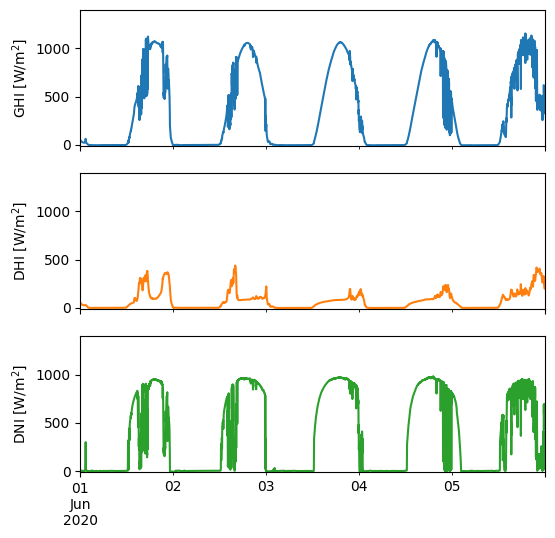

In [17]:
columns = ['ghi', 'dhi', 'dni']
axes = data[columns].plot(
    subplots=True, legend=False, rot=0, figsize=(6, 6), sharex=True)

# Set y-labels and y-limits
for ax, column in zip(axes, columns):
    ax.set_ylabel(f"{column.upper()} [W/m$^2$]")
    ax.set_ylim(-10, 1400)

## References
* Adam R. Jensen, Kevin S. Anderson, William F. Holmgren, Mark A. Mikofski, Clifford W. Hansen, Leland J. Boeman, and Roel Loonen. Pvlib iotools—open-source python functions for seamless access to solar irradiance data. Solar Energy, 266:112092, 2023. doi: [10.1016/j.solener.2023.112092](https://doi.org/10.1016/j.solener.2023.112092).
* B. B. Hicks, J. J. DeLuisi, and D. R. Matt. The NOAA integrated surface irradiance study (ISIS) - a new surface radiation monitoring program. Bulletin of the American Meteorological Society, 77(12):2857–2864, 1996. doi: [10.1175/1520-0477(1996)077<2857:TNISIS>2.0.CO;2](https://doi.org/10.1175/1520-0477(1996)077<2857:TNISIS>2.0.CO;2).